# Imports and Setup

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

2025-12-09 18:51:17.395536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765306277.585561      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765306277.642883      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Load Oxford-IIIT Pet Dataset

In [3]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1765306343.981682      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765306343.982392      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.87LGE1_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.87LGE1_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


# Data Preprocessing: Resize, Augment & Normalize

In [4]:

def resize(input_image, input_mask):
    resized_image = tf.image.resize(images=input_image, size=(128,128))
    resized_mask = tf.image.resize(images=input_mask, size=(128,128))
    return resized_image, resized_mask

In [5]:
# rotate,brightness,shift wagerra
def augment(input_image, input_mask):
    if tf.random.uniform(())>0.5:
        input_image=tf.image.flip_left_right(input_image)
        input_mask=tf.image.flip_left_right(input_mask)
    return input_image, input_mask
        

In [6]:
def normalize(input_image, input_mask):
    return tf.cast(input_image, tf.float32)/255.0, input_mask-1
    

In [7]:
def load_image(datapoint, augment_data=False):
    input_image=datapoint['image']
    input_mask=datapoint['segmentation_mask']
    input_image,input_mask=resize(input_image, input_mask)
    if augment_data:
        input_image,input_mask=augment(input_image,input_mask)
    input_image,input_mask = normalize(input_image,input_mask)
    return input_image,input_mask


# Prepare Datasets

In [9]:
train_dataset = dataset["train"].map(
    lambda x: load_image(x, augment_data=True),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_dataset = dataset["test"].map(
    load_image,
    num_parallel_calls=tf.data.AUTOTUNE
)

# Data Batching & Prefetching

In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Prepare the training dataset:
# 1. Cache the data in memory for faster access
# 2. Shuffle the data with a buffer
# 3. Batch the data
# 4. Repeat the dataset forever (for training)
# 5. Prefetch to improve performance
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Prepare the validation dataset (first 3000 samples from test set)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
# Prepare the test dataset (next 669 samples after validation split)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

# Display Sample Image & Mask

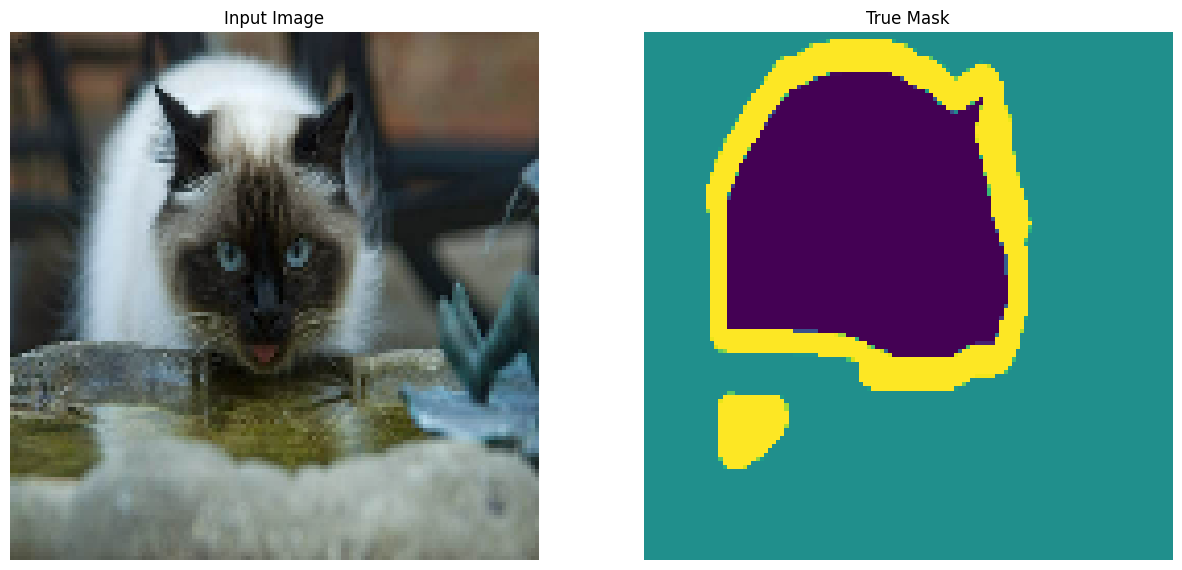

In [11]:
# Function to display input image, true mask, and predicted mask (if provided)
def display(display_list):

    plt.figure(figsize=(15, 15))
    titles = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(titles[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")

    plt.show()

# Get one batch from the training dataset
sample_batch = next(iter(train_batches))

# Randomly choose an index from the batch (0 to 63 , if batch_size = 64)
random_index = np.random.choice(sample_batch[0].shape[0])

# Extract the image and corresponding mask using the random index
sample_image = sample_batch[0][random_index]
sample_mask = sample_batch[1][random_index]

# Display the image and its true mask
display([sample_image, sample_mask])

# U-Net Blocks 

In [12]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [13]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [14]:
def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

# Main U-Net Model Architecture

In [15]:
def build_unet_model():
    # Input layer
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder (Downsampling path)
    f1, p1 = downsample_block(inputs, 64)    # First downsampling
    f2, p2 = downsample_block(p1, 128)       # Second downsampling
    f3, p3 = downsample_block(p2, 256)       # Third downsampling
    f4, p4 = downsample_block(p3, 512)       # Fourth downsampling

    # Bottleneck (Bottom of the "U")
    bottleneck = double_conv_block(p4, 1024)

    # Decoder (Upsampling path with skip connections)
    u6 = upsample_block(bottleneck, f4, 512) # First upsampling
    u7 = upsample_block(u6, f3, 256)         # Second upsampling
    u8 = upsample_block(u7, f2, 128)         # Third upsampling
    u9 = upsample_block(u8, f1, 64)          # Fourth upsampling

    # Output layer
    outputs = layers.Conv2D(
        filters=3,                # 3 classes (background, pet, outline)
        kernel_size=1,            # 1x1 convolution
        padding="same",
        activation="softmax"      # Softmax for multi-class segmentation
    )(u9)

    # Define the model
    unet_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="U-Net")

    return unet_model

In [16]:
unet_model = build_unet_model()

In [17]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

# Training the Model


In [18]:
# Set the number of epochs
NUM_EPOCHS = 10

# Calculate dataset lengths
TRAIN_LENGTH = info.splits["train"].num_examples
TEST_LENGTH = info.splits["test"].num_examples

# Define steps per epoch for training and validation
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

# Early stopping callback: stops training if validation doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

# Train the model
model_history = unet_model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_batches,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stopping]
)

Epoch 1/10


I0000 00:00:1765306467.279053     138 service.cc:148] XLA service 0x7fb1f80a60c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765306467.279825     138 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765306467.279846     138 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1765306467.842140     138 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1765306468.285839     138 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-09 18:54:40.616805: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng50{} for conv (f32[64,512,17,17]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1024,8,8]{3,2,1,0}, f32[1024,512,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwar

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.5596 - loss: 1.0262

W0000 00:00:1765306604.265982     139 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1765306628.106079     141 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1765306642.357748     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765306642.610692     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


57/57 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.5599 - loss: 1.0247 - val_accuracy: 0.5878 - val_loss: 0.8100
Epoch 2/10


W0000 00:00:1765306646.298057     141 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


57/57 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.5909 - loss: 0.8139 - val_accuracy: 0.6977 - val_loss: 0.7151
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7184 - loss: 0.6664 - val_accuracy: 0.7440 - val_loss: 0.5990
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7519 - loss: 0.5911 - val_accuracy: 0.7847 - val_loss: 0.5177
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7828 - loss: 0.5240 - val_accuracy: 0.8024 - val_loss: 0.4850
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8025 - loss: 0.4833 - val_accuracy: 0.8155 - val_loss: 0.4472
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8168 - loss: 0.4504 - val_accuracy: 0.8220 - val_loss: 0.4381
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8246 - loss: 0.4313 - val_accuracy: 0.8414 - val_loss: 0.3869
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8442 - loss: 0.3817 - val_accuracy: 0.8485 - val_loss: 0.3719


In [19]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) # (batch_size, height, width, num_classes)
    pred_mask = pred_mask[..., tf.newaxis]
    # Take all dimensions as-is, and then add a new one at the end.
    return pred_mask[0]

def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = unet_model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step


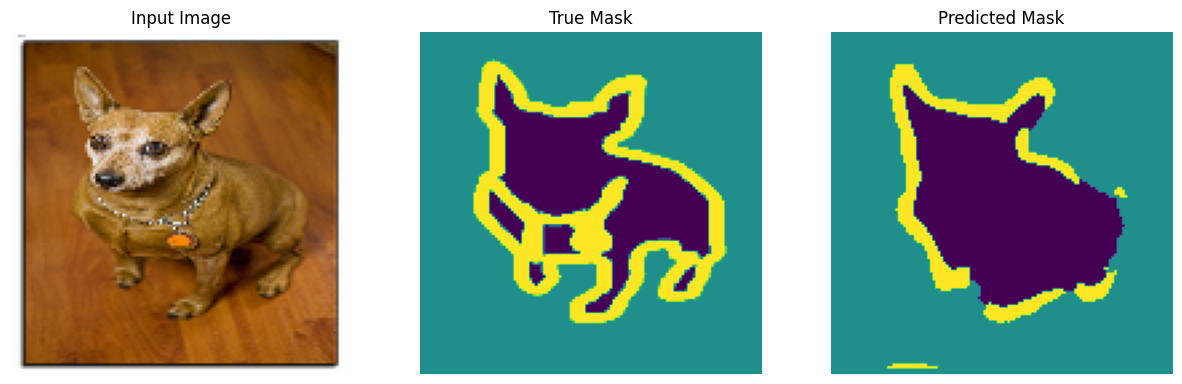

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


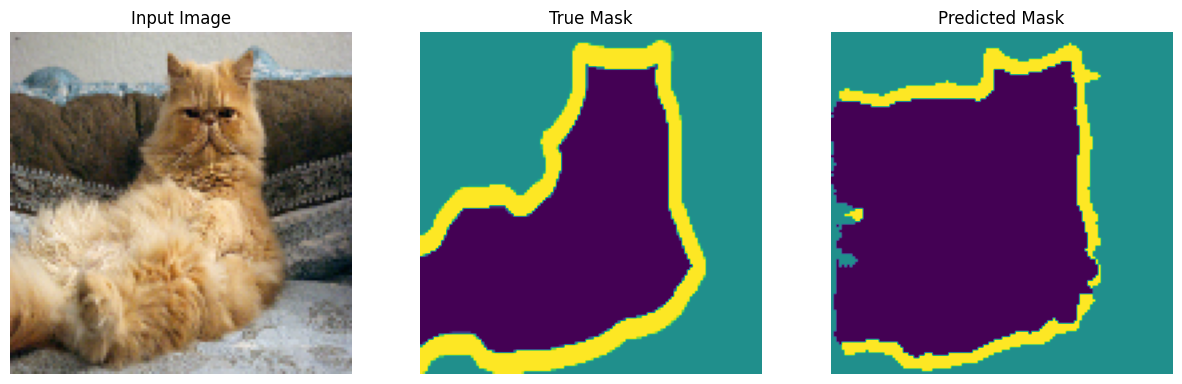

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


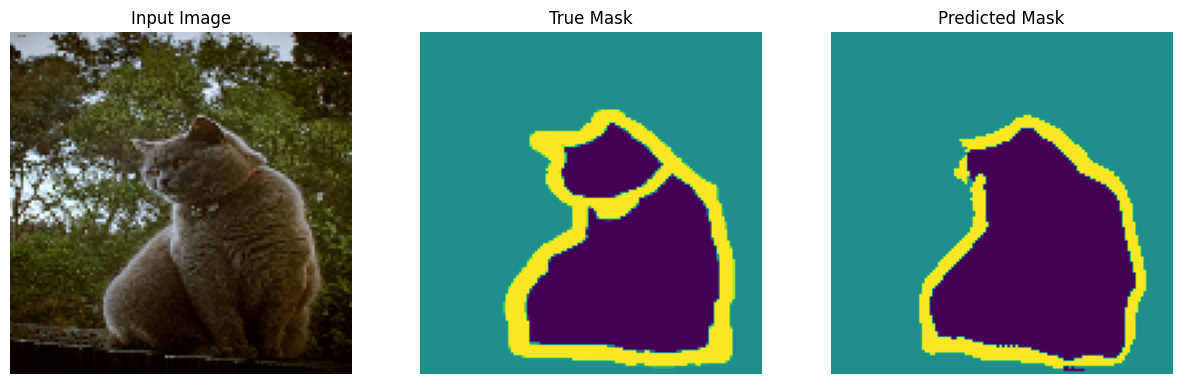

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


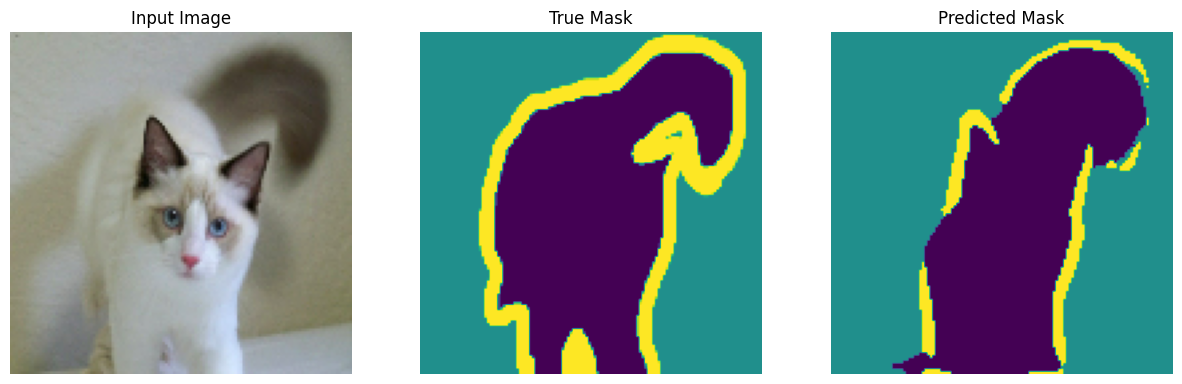

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


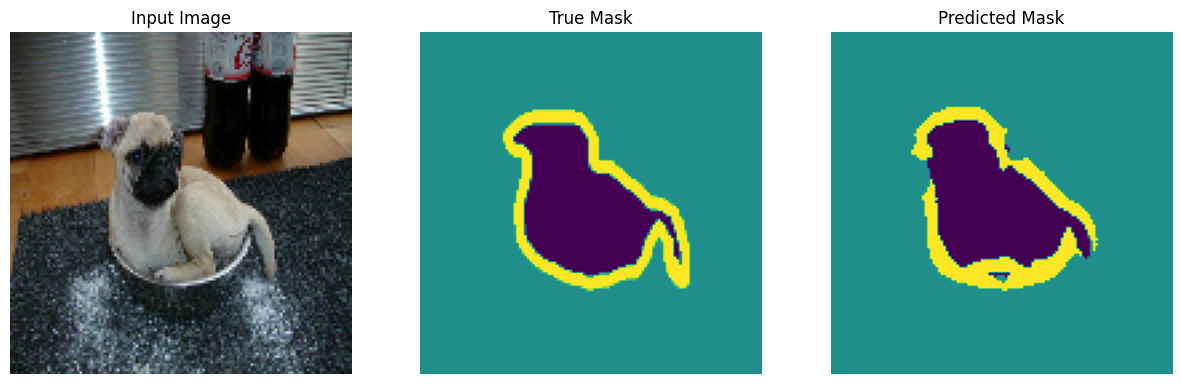

In [21]:
show_predictions(test_batches, 5)